<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_Time-Series_Analytics/S8_Time_Series_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8: Time-series demand forecasting pipeline

## Introduction

Time series demand forecasting is crucial for effective supply chain management. With accurate demand forecasts, businesses can optimize inventory, improve demand planning, enhance sales forecasting, and mitigate supply chain risks.

With recent development in Python and opensources, there are many simple-to-use packages such as [statsmodels](https://www.statsmodels.org/stable/index.html) (mainly for statistical techniques), [Prophet (by Facebook)](https://facebook.github.io/prophet/), [GluonTS (by Amazon)] (https://ts.gluon.ai/stable/), and many other libraries. Most libraries require a specific (but similar) data input format and processes. Thus, the most important step to use such packages is to prepare the data in the right format.

There are also opensource libaries that are built upon many time-series forecasting packages and provide interfaces to many time-series algorithms such as [sktime](https://www.sktime.net/en/latest/index.html) and [darts](https://unit8co.github.io/darts/). These time-series forecasting interfaces greatly simplify forecasting with its intuitive API and diverse range of models, including classical statistical methods and modern machine learning approaches including deep-learning-based models. An illustration of a time-series pipeline based on the case [1] is depicted below.

<figure>
<center>
<img src='https://github.com/acedesci/scanalytics/blob/master/EN/S08%20Time-Series%20using%20ML/BBD_forecasts.png?raw=true'/>
<figcaption>Forecasting pipeline as depicted in [1]</figcaption></center>
</figure>

This notebook provide a simple walkthrough for an implementation of time-series forecasting pipeline using `darts`. At the end of the notebook, it also demonstrates time-phased dynamic inventory policy that can be calculated from the forecasts from various forecasting models. The quality of this inventory policy can then be measured through a simulation which has been covered in an earlier session on `DataFrame`.

[1] Dodin, P., Xiao, J., Adulyasak, Y., Alamdari, N.E., Gauthier, L., Grangier, P., Lemaitre, P. and Hamilton, W.L., 2023. **Bombardier aftermarket demand forecast with machine learning.** *INFORMS Journal on Applied Analytics*, 53(6), pp.425-445.

**Code block description**: We first install `darts` (this must be run every time a new colab notebook is open).

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 13.2 MB/s eta 0:00:0

## Data inputs

This code block primarily  sets up the environment for time series analysis using models available in `darts`.

*Notable remarks:*

*   `data = pd.read_csv(..., index_col='ds')`: Reads time series data from a CSV file located at the given URL. It assumes the file has a column named 'ds' that represents the dates or timestamps and sets it as the index of the DataFrame.

*   `y = data['y']`: Extracts the time series data (likely the demand values) from the 'y' column of the DataFrame and assigns it to the variable y.

*   `plot_n_points = 104 `: Sets the number of data points to be used for plotting.

*   `test_n_points = 65`: Sets the number of data points to be used for testing the forecasting models.

In [ ]:
import darts
from darts.models import TBATS, AutoARIMA, Prophet, ExponentialSmoothing, Theta, NaiveSeasonal, Croston, NBEATSModel
from darts.models import NaiveEnsembleModel, RegressionEnsembleModel
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape, mase, rmsse, rmse, merr
from darts import TimeSeries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# read historical time-series data (demand)
data = pd.read_csv('https://bit.ly/m5simple', index_col='ds')
data.index = pd.to_datetime(data.index)

n_periods = len(data.index)
print(n_periods)

y = data['y']

plot_n_points = 104
test_n_points = 65


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


177


## Define key functions

This code block defines the following functions that will be called often in the pipeline.

**Function** `calculate_test_errors`:

This function calculates and return various error metrics for a time series forecast.

Input:

`test_series`: The actual values of the time series during the testing period.
`forecast_series`: The predicted values generated by a forecasting model during the testing period.

Process:

It uses functions from the darts.metrics module (`mape, smape, rmsse, rmse, merr`) to calculate the following error metrics (see [Darts error metrics](https://unit8co.github.io/darts/generated_api/darts.metrics.html)):


* MAPE: Mean Absolute Percentage Error (from function `mape`)
* sMAPE: Symmetric Mean Absolute Percentage Error (from function `smape`)
* RMSSE: Root Mean Squared Scaled Error (from function `rmsse`)
* RMSE: Root Mean Squared Error (from function `rmse`)
* ME: Mean Error (from function `merr`)
* Norm_ME: Mean Error normalized by the mean of actual demand

Output:
The function returns the errors DataFrame containing the calculated error metrics for the model.

**Function** `add_ranks`:

This function is used to add rank columns to a DataFrame based on the values in existing columns, It returns the modified DataFrame with the added rank columns.

In [ ]:
# functions to return test errors

def calculate_test_errors(test_series, forecast_series, series_name = 'y', print_results = False, skip_mape = False):
  m_name = forecast_series.name
  test = TimeSeries.from_series(test_series)
  forecast = TimeSeries.from_series(forecast_series)


  if not skip_mape:
    m_mape = mape(test, forecast)
    m_smape = smape(test, forecast)

  m_rmsse = rmsse(test, forecast, insample = train)
  m_rmse = rmse(test, forecast)
  m_merr = merr(test, forecast)

  if print_results:
    if not skip_mape:
      print(f"model {m_name} obtains Mean Absolute Percentage Error: {m_mape:.2f}%")
      print(f"model {m_name} obtains symmetric Mean Absolute Percentage Error: {m_smape:.2f}%")

    print(f"model {m_name} obtains Root Mean Squared Scaled Error: {m_rmsse:.2f}")
    print(f"model {m_name} obtains Root Mean Squared Error: {m_rmse:.2f}")
    print(f"model {m_name} obtains Mean Error: {m_merr:.2f}")

  test_mean = test.pd_series().mean()

  if not skip_mape:
    column_names=['SeriesName', 'Model', 'MAPE', 'sMAPE', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
    errors = pd.DataFrame(columns=column_names)
    errors.loc[0] = [series_name, m_name, m_mape, m_smape, m_rmsse, m_rmse, m_rmse/test_mean, m_merr, m_merr/test_mean]
  else:
    column_names=['SeriesName', 'Model', 'RMSSE', 'RMSE', 'Norm_RMSE', 'ME', 'Norm_ME']
    errors = pd.DataFrame(columns=column_names)
    errors.loc[0] = [series_name, m_name, m_rmsse, m_rmse, m_rmse/test_mean, m_merr, m_merr/test_mean]

  return errors

def add_ranks(df, ascending=True):
  for col in df.columns[2:]:
    df['Rank_'+col] = df[col].abs().rank(ascending=ascending)
  return df



## Pipeline 1: Forecasting and evaluation using two-fold validation

The code block calls and evaluates various time series forecasting models in the `darts` library. It first prepares the data, visualizes the actual values, and defines a list of forecasting models, including ensembles. Then, it iteratively trains each model, generates forecasts, calculates error metrics. Finally, it combines and displays the errors and ranks of each model, providing a performance comparison based on different models for the given dataset.

The training and evaluation of this pipeline is based on a two-fold validation process where data is split only into one training and one test set at a given split point. The predictions are evaluated against the actual values in the test set (which is not used in the training process).


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/r5lwbkmv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/wbmkld91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71080', 'data', 'file=/tmp/tmppdw380vz/r5lwbkmv.json', 'init=/tmp/tmppdw380vz/wbmkld91.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modell7tpftgh/prophet_model-20241226081747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:pytorch_lightning.utilities.rank_ze

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,SeriesName,Model,MAPE,sMAPE,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,Rank_MAPE,Rank_sMAPE,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME
0,y,NaiveSeasonal(K,12.148744,13.103344,1.100328,516.358194,0.136018,460.000000,0.121172,9.0,9.0,9.0,9.0,9.0,9.0,9.0
1,y,ExponentialSmoo,7.082400,7.290990,0.687155,322.466081,0.084943,121.163001,0.031916,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,y,AutoARIMA(),8.810138,9.346130,0.869174,407.883240,0.107443,320.869908,0.084523,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,y,Theta(),7.502185,7.884801,0.768559,360.666728,0.095006,243.114795,0.064041,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,y,Prophet(),8.368235,8.812584,0.807830,379.096094,0.099860,267.909300,0.070572,3.0,3.0,3.0,3.0,3.0,3.0,3.0
5,y,NBEATSModel(inp,11.345640,12.229798,1.085665,509.477185,0.134205,430.995376,0.113532,8.0,8.0,8.0,8.0,8.0,8.0,8.0
6,y,Croston(),9.457731,10.076149,0.924320,433.761845,0.114260,353.182812,0.093034,6.0,6.0,6.0,6.0,6.0,6.0,6.0
7,y,NaiveEnsembleMo,9.087233,9.666369,0.887205,416.344620,0.109672,352.166254,0.092767,5.0,5.0,5.0,5.0,5.0,5.0,5.0
8,y,RegressionEnsem,10.349097,11.061851,0.973938,457.046625,0.120394,401.775876,0.105835,7.0,7.0,7.0,7.0,7.0,7.0,7.0


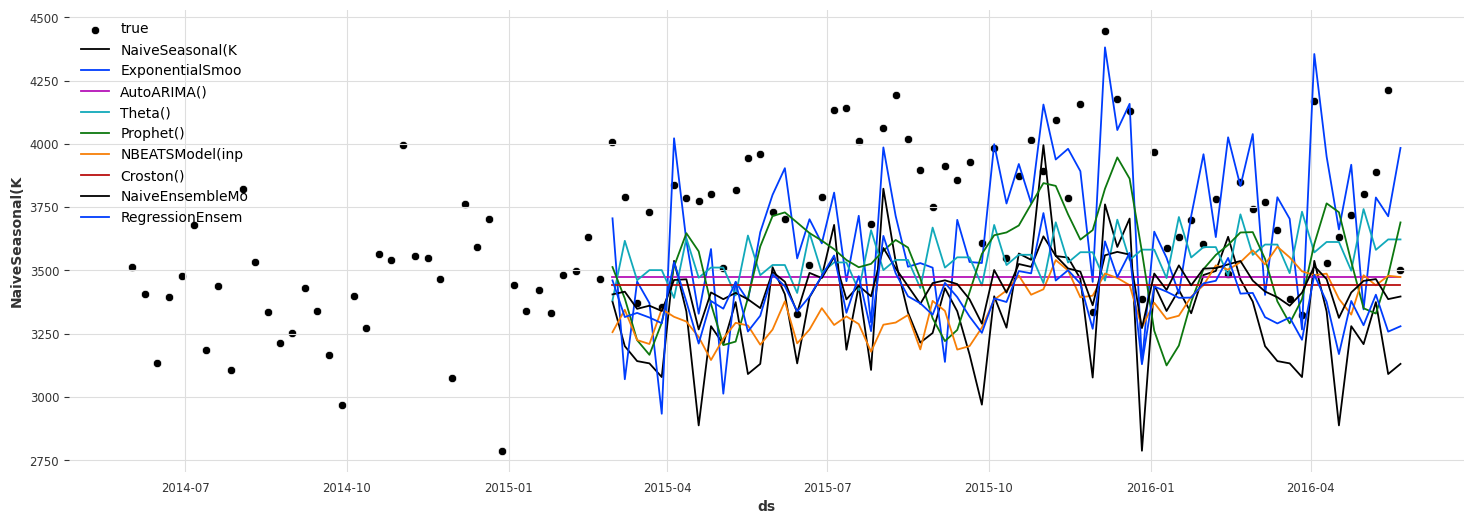

In [ ]:
# Single split (two-fold)

plt.figure(figsize=(18,6))

sns.scatterplot(x = y[-plot_n_points:].index, y = y[-plot_n_points:].values, label = 'true')

y_timeseries = TimeSeries.from_series(y)

ensemble_models = [NaiveSeasonal(K=52), Theta(season_mode = SeasonalityMode.ADDITIVE), Croston()]

list_models = [NaiveSeasonal(K=52),
               ExponentialSmoothing(),
               AutoARIMA(), \
               Theta(), \
               Prophet(), \
               NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50), \
               Croston(),\
               NaiveEnsembleModel(forecasting_models=ensemble_models), \
               RegressionEnsembleModel(forecasting_models=ensemble_models, regression_train_n_points=13)]

list_errors = []
df_forecasts = pd.DataFrame()
df_forecasts['y'] = y

start = len(y)-test_n_points
train, test = y_timeseries.split_before(start)

for model in list_models:
  m_name = str(model)[:15]
  model.fit(train)
  forecast_series = model.predict(len(test)).pd_series()
  forecast_series.name = m_name
  errors = calculate_test_errors(test.pd_series(), forecast_series, series_name = 'y')
  sns.lineplot(data = forecast_series, label = forecast_series.name)
  list_errors.append(errors)
  df_forecasts[forecast_series.name] = forecast_series

pd_errors = pd.concat(list_errors, ignore_index = True)
pd_errors = add_ranks(pd_errors)

pd_errors

## Define rolling forecasts and plot functions

**Function** `eval_model_rolling_forecasts`:

This function simulates a real-world forecasting scenario where one would retrain the model periodically with new data to make future predictions. It provides a more realistic evaluation of the model's performance over time compared to a single train-test split. This functions requires the **following inputs**:

* `model`: darts models (see [darts forecasting models](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html))
* `series`: a series containing the entire time-series data
* `start`: the first starting point of the forecasting evaluation
* `fh`: length of the forecast horizon
* `stride`: the retraining (forecast update) internal (i.e., new forecasts are produced every `stride` periods). This value must be $\leq$ `fh`

The model returns a series containing the predictions that are produced using a rolling update of every `stride` periods. Only the most recent values of the predictions are kept in the series.

**Function** `plot_forecasts`:

 This function is used to visualize time series data from a DataFrame containing actual and forecasted data.It generates a plot with actual values displayed as scatter points and forecasts from different models represented as lines.

In [ ]:

def eval_model_rolling_forecasts(model, series, start, fh, stride, series_name = 'y'):
  m_name = str(model)[:15]

  timeseries = TimeSeries.from_series(series)
  list_hist_rolling_forecasts = []
  for starting_point in range(start, len(timeseries), stride):
    train, val = timeseries.split_before(starting_point)
    forecast_horizon = min(fh, len(val))
    forecasts = model.fit(train).predict(forecast_horizon)
    list_hist_rolling_forecasts.append(forecasts.pd_series())

  last_fold = len(list_hist_rolling_forecasts)-1
  hist_rolling_forecasts = list_hist_rolling_forecasts[last_fold]

  for fold in range(last_fold):
    hist_rolling_forecasts = pd.concat([hist_rolling_forecasts, list_hist_rolling_forecasts[fold][:stride]])

  hist_rolling_forecasts.name = m_name
  print(hist_rolling_forecasts.name)

  return hist_rolling_forecasts


In [ ]:
df_forecasts

,y,NaiveSeasonal(K,ExponentialSmoo,AutoARIMA(),Theta(),Prophet(),NBEATSModel(inp,Croston(),NaiveEnsembleMo,RegressionEnsem
ds,,,,,,,,,,
2013-01-06,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-13,2057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-20,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-27,2869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-03,3441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016-04-24,3721,3280.0,3917.610634,3475.39163,3499.210672,3534.688891,3325.663619,3443.078726,3413.070906,3379.489693
2016-05-01,3802,3209.0,3346.224458,3475.39163,3742.516433,3350.744001,3481.279054,3443.078726,3458.741918,3283.568401
2016-05-08,3890,3375.0,3788.283294,3475.39163,3581.373692,3329.856731,3441.331700,3443.078726,3466.018989,3404.300784


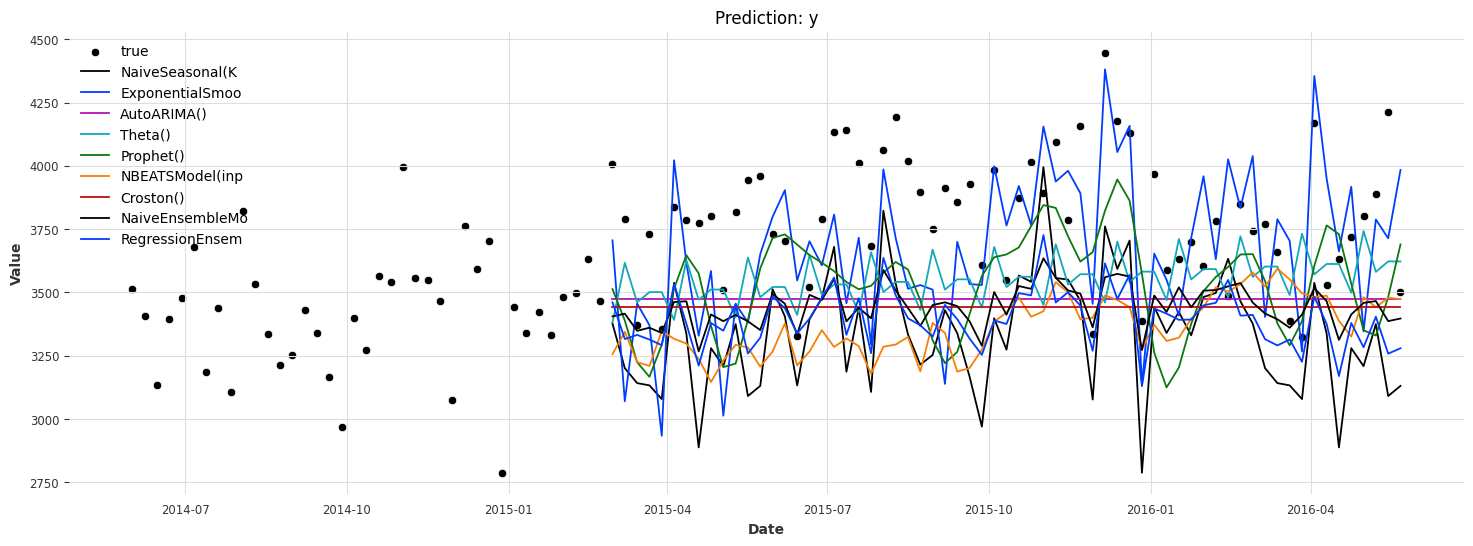

In [ ]:
def plot_forecasts(df_forecasts, n_points, series_name = 'y', plot_name = 'Prediction'):
  plt.figure(figsize=(18,6))
  plt.title(plot_name+": " + series_name)
  plt.xlabel("Date")
  plt.ylabel("Value")
  y = df_forecasts['y']
  sns.scatterplot(x = y[-n_points:].index, y = y[-n_points:].values, label = 'true')

  for model in df_forecasts.columns[1:]:
    sns.lineplot(data = df_forecasts[model][-n_points:], label = model)

# plot_forecasts(df_forecasts, n_points=plot_n_points)

## Pipeline 2: Forecasting and evaluation using sequential validation

This code block is similar to pipeline 1 but it simulates and evaluates the forecasts on a rolling basis using the previously defined function `eval_model_rolling_forecasts(...)`.

NaiveSeasonal(K
ExponentialSmoo
AutoARIMA()
Theta()
Croston()
NaiveEnsembleMo
RegressionEnsem


,SeriesName,Model,MAPE,sMAPE,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,Rank_MAPE,Rank_sMAPE,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME
0,y,NaiveSeasonal(K,10.674152,11.390269,0.993654,466.298798,0.122831,353.769231,0.093189,7.0,7.0,7.0,7.0,7.0,7.0,7.0
0,y,ExponentialSmoo,7.424452,7.331719,0.726633,340.991987,0.089823,-67.934413,-0.017895,6.0,6.0,6.0,6.0,6.0,5.0,5.0
0,y,AutoARIMA(),6.901420,6.787874,0.663463,311.347702,0.082014,-54.258305,-0.014293,4.0,4.0,4.0,4.0,4.0,3.0,3.0
0,y,Theta(),6.814157,6.746608,0.651858,305.901789,0.080580,-32.447474,-0.008547,3.0,3.0,3.0,3.0,3.0,1.0,1.0
0,y,Croston(),6.421460,6.491812,0.630310,295.790037,0.077916,63.358560,0.016690,2.0,2.0,2.0,2.0,2.0,4.0,4.0
0,y,NaiveEnsembleMo,6.173818,6.357114,0.622906,292.315289,0.077001,128.688690,0.033899,1.0,1.0,1.0,1.0,1.0,6.0,6.0
0,y,RegressionEnsem,7.114506,7.057938,0.712071,334.158307,0.088023,-40.791643,-0.010745,5.0,5.0,5.0,5.0,5.0,2.0,2.0


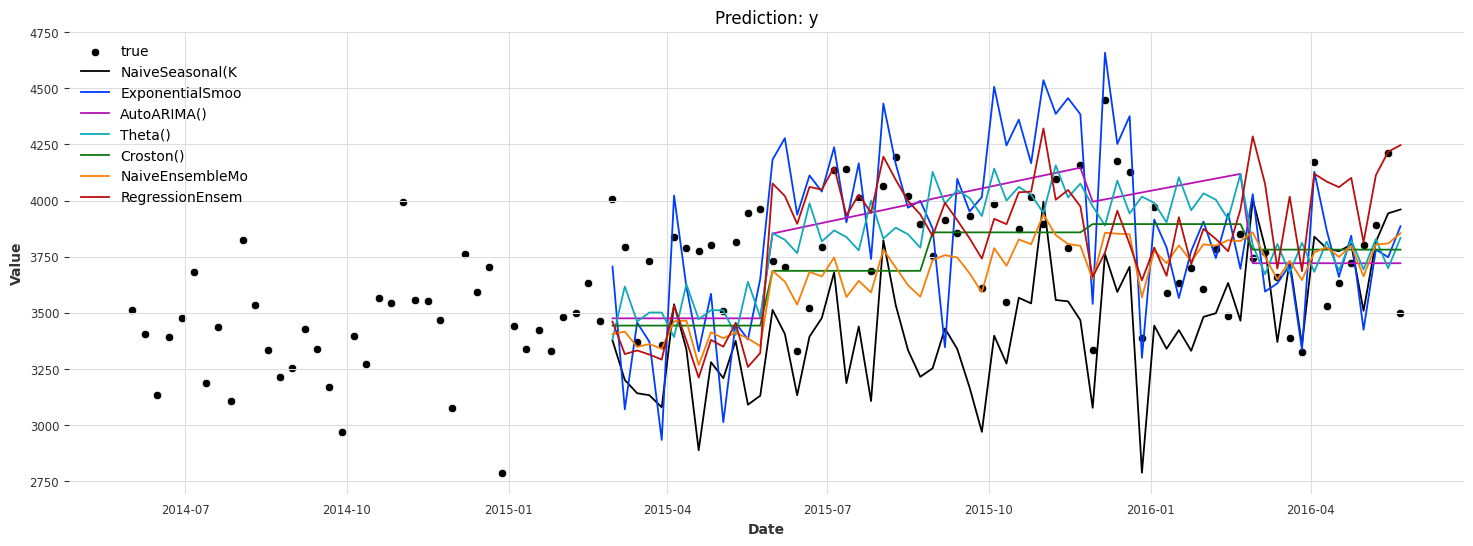

In [ ]:
# rolling forecasts evaluation (multifold sequential validation)

val_size = test_n_points
y_timeseries = TimeSeries.from_series(y)
start = len(y)-val_size
fh = 13
stride=13

ensemble_models = [NaiveSeasonal(K=52), Theta(season_mode = SeasonalityMode.ADDITIVE), Croston()]

list_models = [NaiveSeasonal(K=52),
               ExponentialSmoothing(),
               AutoARIMA(), \
               Theta(), \
               # Prophet(), \
               # NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50), \
               Croston(),\
               NaiveEnsembleModel(forecasting_models=ensemble_models), \
               RegressionEnsembleModel(forecasting_models=ensemble_models, regression_train_n_points=13)
               ]

list_errors = []
df_forecasts = pd.DataFrame()
df_forecasts['y'] = y
train, test = y_timeseries.split_before(start)

for model in list_models:
  forecast_series = eval_model_rolling_forecasts(model, y, start, fh, stride)
  errors = calculate_test_errors(test.pd_series(), forecast_series)
  list_errors.append(errors)
  df_forecasts[forecast_series.name] = forecast_series

pd_errors = pd.concat(list_errors)
pd_errors = add_ranks(pd_errors)

plot_forecasts(df_forecasts, plot_n_points)

pd_errors

## Pipeline 3: Automating forecasting and sequential validation on multiple items

This code block is similar to pipeline 2 that performs rolling forecasts. The code automate the predictions of multiple items through iterative process.

In [ ]:
# pipeline to run forecast for multiple items

import time

# state-item level
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/processed_data/m5data_CA_item_state_rand.csv'

# store-item level (slow-moving)
# url = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/data/M5/processed_data/m5data_CA_item_store_n25_cv.csv'

data = pd.read_csv(url, index_col='ds')
data.index = pd.to_datetime(data.index)

list_items = data.columns[:5]
print(list_items)

val_size = test_n_points
start = len(data.index)-val_size
fh = 13
stride = 13

ensemble_models = [NaiveSeasonal(K=52), Theta(season_mode = SeasonalityMode.ADDITIVE), Croston()]

list_models = [NaiveSeasonal(K=52),
               # ExponentialSmoothing(),
               AutoARIMA(), \
               Theta(season_mode = SeasonalityMode.ADDITIVE), \
               Prophet(), \
               # NBEATSModel(input_chunk_length=52, output_chunk_length=52, n_epochs=50), \
               Croston(),\
               NaiveEnsembleModel(forecasting_models=ensemble_models), \
               RegressionEnsembleModel(forecasting_models=ensemble_models, regression_train_n_points=13)
               ]

pd_all_errors = pd.DataFrame()

list_forecasts = []

for item in list_items:

  print("Item: "+str(item))
  y = data[item]
  df_forecasts = pd.DataFrame()
  df_forecasts['y'] = y

  y_timeseries = TimeSeries.from_series(y)
  train, test = y_timeseries.split_before(start)

  list_errors = []

  for model in list_models:
    start_time = time.time()
    forecast_series = eval_model_rolling_forecasts(model, y, start, fh, stride, series_name = item)
    runtime = time.time()-start_time
    forecast_series = forecast_series.clip(lower=0)
    errors = calculate_test_errors(test.pd_series(), forecast_series, series_name = item, skip_mape = True)
    errors['runtime'] = [runtime]
    list_errors.append(errors)
    df_forecasts[forecast_series.name] = forecast_series

  pd_errors = add_ranks(pd.concat(list_errors))

  pd_all_errors = pd.concat([pd_all_errors, pd_errors])
  list_forecasts.append(df_forecasts)

Index(['CA_HOBBIES_1_002', 'CA_HOBBIES_1_004', 'CA_HOBBIES_1_005',
       'CA_HOBBIES_1_006', 'CA_HOBBIES_1_007'],
      dtype='object')
Item: CA_HOBBIES_1_002
NaiveSeasonal(K


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AutoARIMA()
Theta(season_mo


DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/evgcuti1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/pkt9ts6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28909', 'data', 'file=/tmp/tmppdw380vz/evgcuti1.json', 'init=/tmp/tmppdw380vz/pkt9ts6u.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modelyhbp1m4y/prophet_model-20241226082027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Prophet()
Croston()
NaiveEnsembleMo
RegressionEnsem
Item: CA_HOBBIES_1_004
NaiveSeasonal(K


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/fjjvv0u_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/zest4go0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2681', 'data', 'file=/tmp/tmppdw380vz/fjjvv0u_.json', 'init=/tmp/tmppdw380vz/zest4go0.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modelr8tsx3jz/prophet_model-20241226082048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

AutoARIMA()
Theta(season_mo


08:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/3aopff1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/zsse802h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53509', 'data', 'file=/tmp/tmppdw380vz/3aopff1o.json', 'init=/tmp/tmppdw380vz/zsse802h.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modelxmb05k1_/prophet_model-20241226082048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:48 - cmdstanpy - INFO - Chain [1] 

Prophet()
Croston()
NaiveEnsembleMo
RegressionEnsem
Item: CA_HOBBIES_1_005
NaiveSeasonal(K


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/z92a_xnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/xf85_45i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41007', 'data', 'file=/tmp/tmppdw380vz/z92a_xnw.json', 'init=/tmp/tmppdw380vz/xf85_45i.json', 'output', 'file=/tmp/tmppdw380vz/prophet_model8jxgm9wm/prophet_model-20241226082133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

AutoARIMA()
Theta(season_mo


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/tbqdabqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/v4k5oz02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87099', 'data', 'file=/tmp/tmppdw380vz/tbqdabqn.json', 'init=/tmp/tmppdw380vz/v4k5oz02.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modelfd2r_y8h/prophet_model-20241226082133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality

Prophet()
Croston()
NaiveEnsembleMo
RegressionEnsem
Item: CA_HOBBIES_1_006
NaiveSeasonal(K


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/0wvf734o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/ue5ruhmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99834', 'data', 'file=/tmp/tmppdw380vz/0wvf734o.json', 'init=/tmp/tmppdw380vz/ue5ruhmz.json', 'output', 'file=/tmp/tmppdw380vz/prophet_model7tugyl7c/prophet_model-20241226082142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

AutoARIMA()
Theta(season_mo


08:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/202ucf67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/r2tyt1sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50863', 'data', 'file=/tmp/tmppdw380vz/202ucf67.json', 'init=/tmp/tmppdw380vz/r2tyt1sw.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modelny51nwqf/prophet_model-20241226082142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:42 - cmdstanpy - INFO - Chain [1] 

Prophet()
Croston()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/8c46c617.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/tdlafr4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45813', 'data', 'file=/tmp/tmppdw380vz/8c46c617.json', 'init=/tmp/tmppdw380vz/tdlafr4m.json', 'output', 'file=/tmp/tmppdw380vz/prophet_modelsz5i02wy/prophet_model-20241226082154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

NaiveEnsembleMo
RegressionEnsem
Item: CA_HOBBIES_1_007
NaiveSeasonal(K
AutoARIMA()
Theta(season_mo


08:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/x00qqe91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdw380vz/jflbq0bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82501', 'data', 'file=/tmp/tmppdw380vz/x00qqe91.json', 'init=/tmp/tmppdw380vz/jflbq0bf.json', 'output', 'file=/tmp/tmppdw380vz/prophet_models4_sambd/prophet_model-20241226082155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:55 - cmdstanpy - INFO - Chain [1] 

Prophet()
Croston()
NaiveEnsembleMo
RegressionEnsem


,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,runtime,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME,Rank_runtime
0,CA_HOBBIES_1_002,NaiveSeasonal(K,0.793161,3.355822,0.634094,-0.892308,-0.168605,0.032823,3.0,3.0,3.0,5.0,5.0,1.0
0,CA_HOBBIES_1_002,AutoARIMA(),0.839902,3.553582,0.671462,-0.891542,-0.168460,13.491775,4.0,4.0,4.0,4.0,4.0,7.0
0,CA_HOBBIES_1_002,Theta(season_mo,0.842698,3.565411,0.673697,-0.105700,-0.019972,0.131690,5.0,5.0,5.0,1.0,1.0,3.0
0,CA_HOBBIES_1_002,Prophet(),0.693455,2.933969,0.554384,-0.929834,-0.175695,3.341399,1.0,1.0,1.0,6.0,6.0,6.0
0,CA_HOBBIES_1_002,Croston(),0.920904,3.896297,0.736219,-0.833177,-0.157432,0.034803,6.0,6.0,6.0,3.0,3.0,2.0
0,CA_HOBBIES_1_002,NaiveEnsembleMo,0.695761,2.943729,0.556228,-0.610395,-0.115336,0.190316,2.0,2.0,2.0,2.0,2.0,4.0
0,CA_HOBBIES_1_002,RegressionEnsem,3.231055,13.670420,2.583073,-5.611671,-1.060345,0.391350,7.0,7.0,7.0,7.0,7.0,5.0
0,CA_HOBBIES_1_004,NaiveSeasonal(K,1.363026,25.760435,0.290045,-14.369231,-0.161788,0.032769,7.0,7.0,7.0,5.0,5.0,2.0
0,CA_HOBBIES_1_004,AutoARIMA(),0.836493,15.809265,0.178001,-6.412398,-0.072199,16.053517,1.0,1.0,1.0,1.0,1.0,7.0
0,CA_HOBBIES_1_004,Theta(season_mo,0.863101,16.312129,0.183663,-7.508196,-0.084537,0.140087,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
pd_all_errors





,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,runtime,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME,Rank_runtime
0,CA_HOBBIES_1_002,NaiveSeasonal(K,0.793161,3.355822,0.634094,-0.892308,-0.168605,0.032823,3.0,3.0,3.0,5.0,5.0,1.0
0,CA_HOBBIES_1_002,AutoARIMA(),0.839902,3.553582,0.671462,-0.891542,-0.168460,13.491775,4.0,4.0,4.0,4.0,4.0,7.0
0,CA_HOBBIES_1_002,Theta(season_mo,0.842698,3.565411,0.673697,-0.105700,-0.019972,0.131690,5.0,5.0,5.0,1.0,1.0,3.0
0,CA_HOBBIES_1_002,Prophet(),0.693455,2.933969,0.554384,-0.929834,-0.175695,3.341399,1.0,1.0,1.0,6.0,6.0,6.0
0,CA_HOBBIES_1_002,Croston(),0.920904,3.896297,0.736219,-0.833177,-0.157432,0.034803,6.0,6.0,6.0,3.0,3.0,2.0
0,CA_HOBBIES_1_002,NaiveEnsembleMo,0.695761,2.943729,0.556228,-0.610395,-0.115336,0.190316,2.0,2.0,2.0,2.0,2.0,4.0
0,CA_HOBBIES_1_002,RegressionEnsem,3.231055,13.670420,2.583073,-5.611671,-1.060345,0.391350,7.0,7.0,7.0,7.0,7.0,5.0
0,CA_HOBBIES_1_004,NaiveSeasonal(K,1.363026,25.760435,0.290045,-14.369231,-0.161788,0.032769,7.0,7.0,7.0,5.0,5.0,2.0
0,CA_HOBBIES_1_004,AutoARIMA(),0.836493,15.809265,0.178001,-6.412398,-0.072199,16.053517,1.0,1.0,1.0,1.0,1.0,7.0
0,CA_HOBBIES_1_004,Theta(season_mo,0.863101,16.312129,0.183663,-7.508196,-0.084537,0.140087,3.0,3.0,3.0,3.0,3.0,3.0


In [1]:
pd_all_errors[pd_all_errors.columns[1:]].groupby('Model').mean().sort_values(by=['Rank_RMSSE'])

NameError: name 'pd_all_errors' is not defined

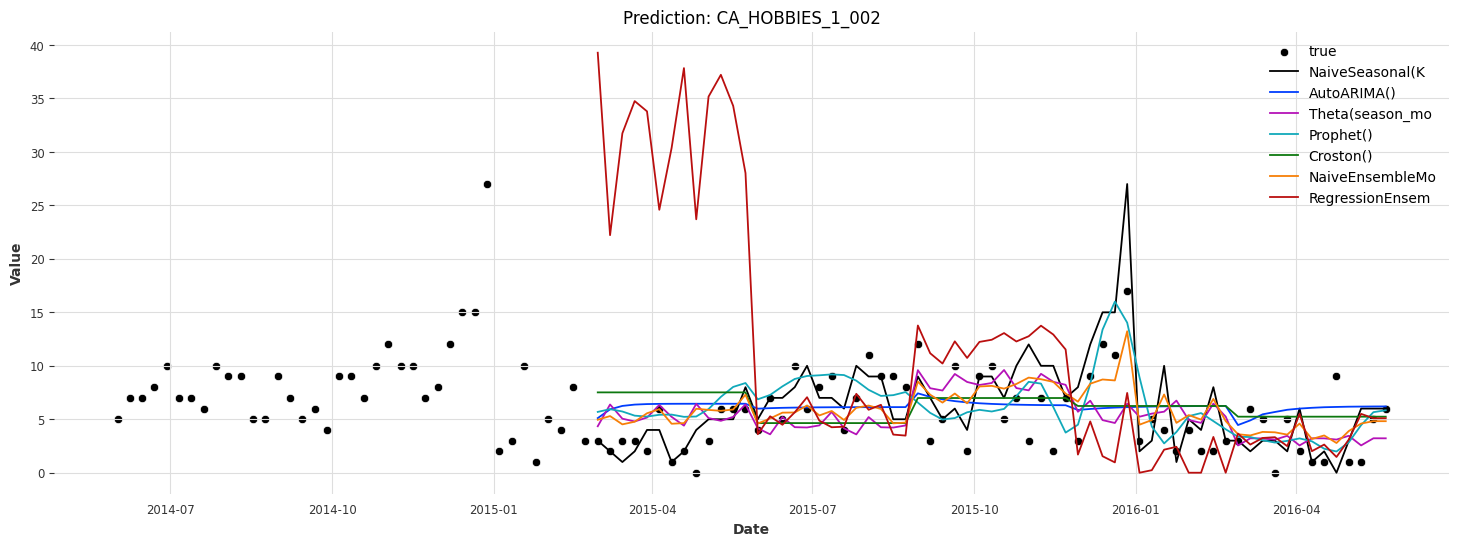

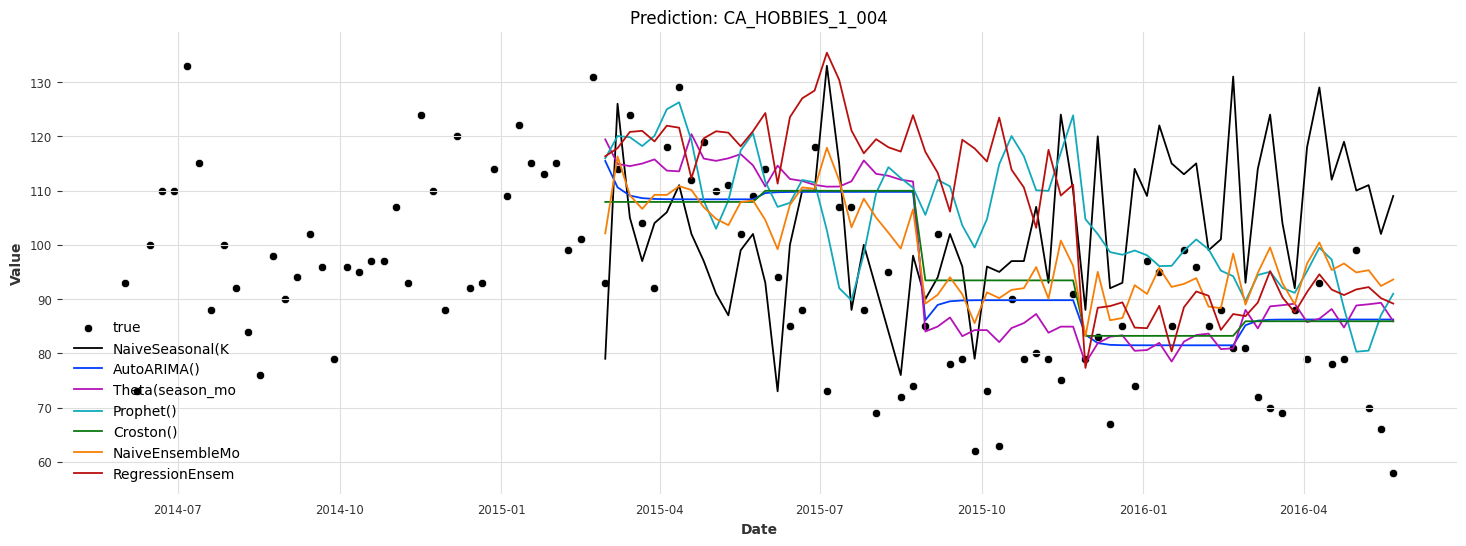

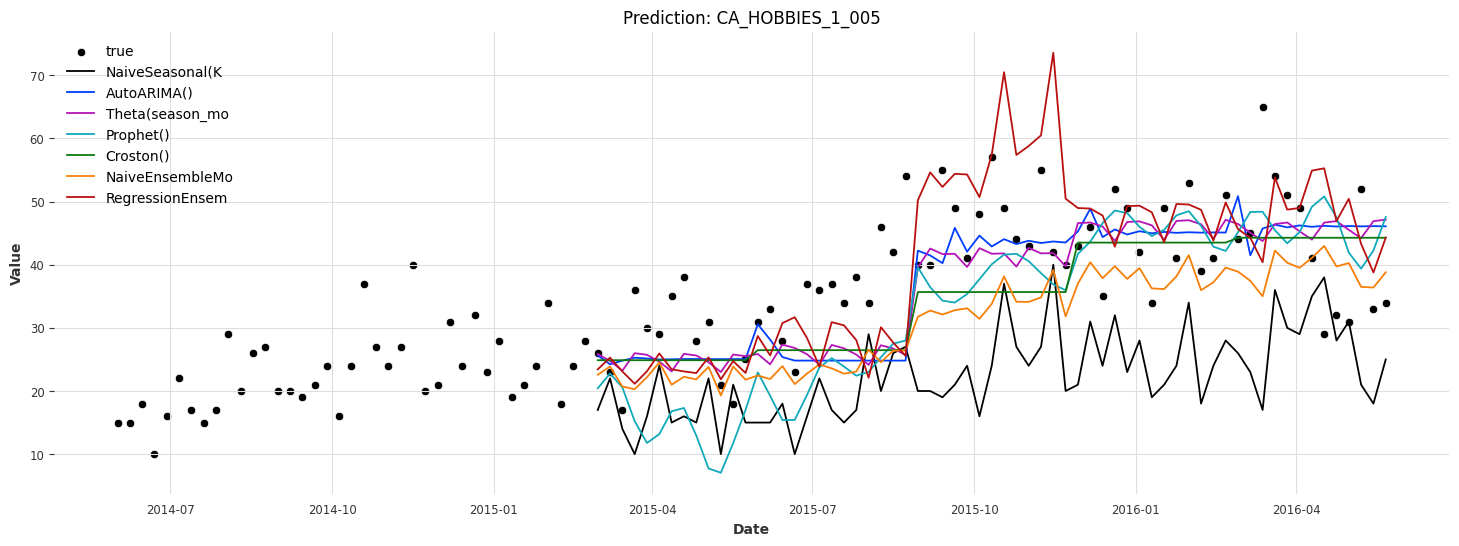

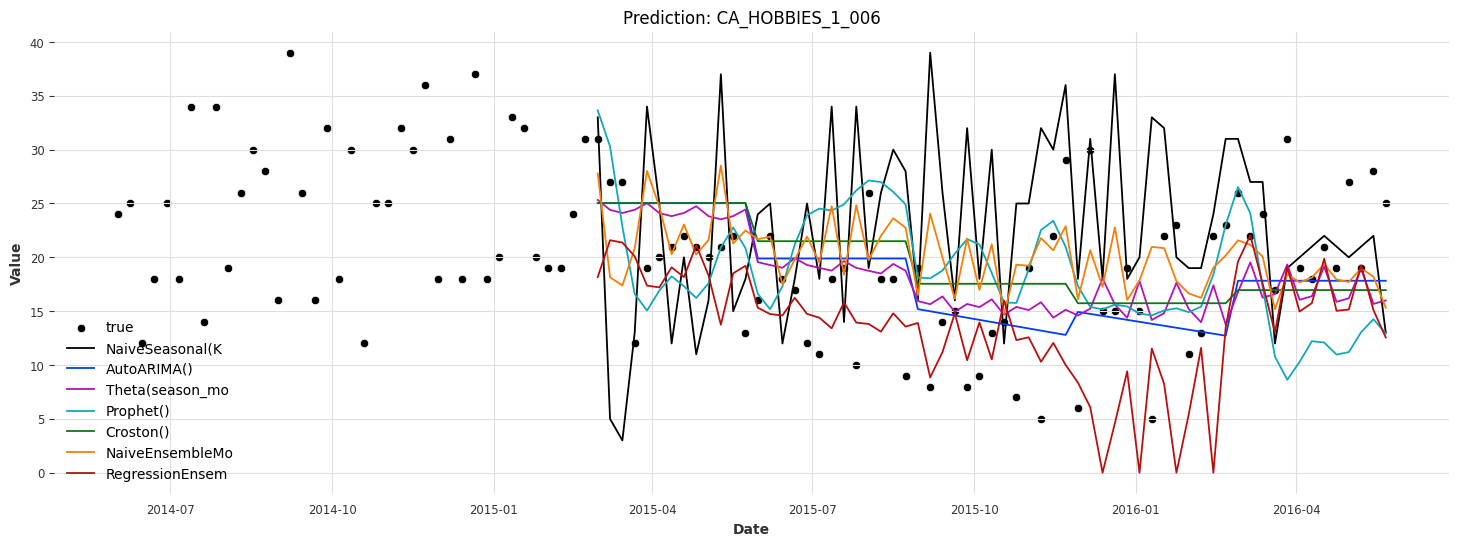

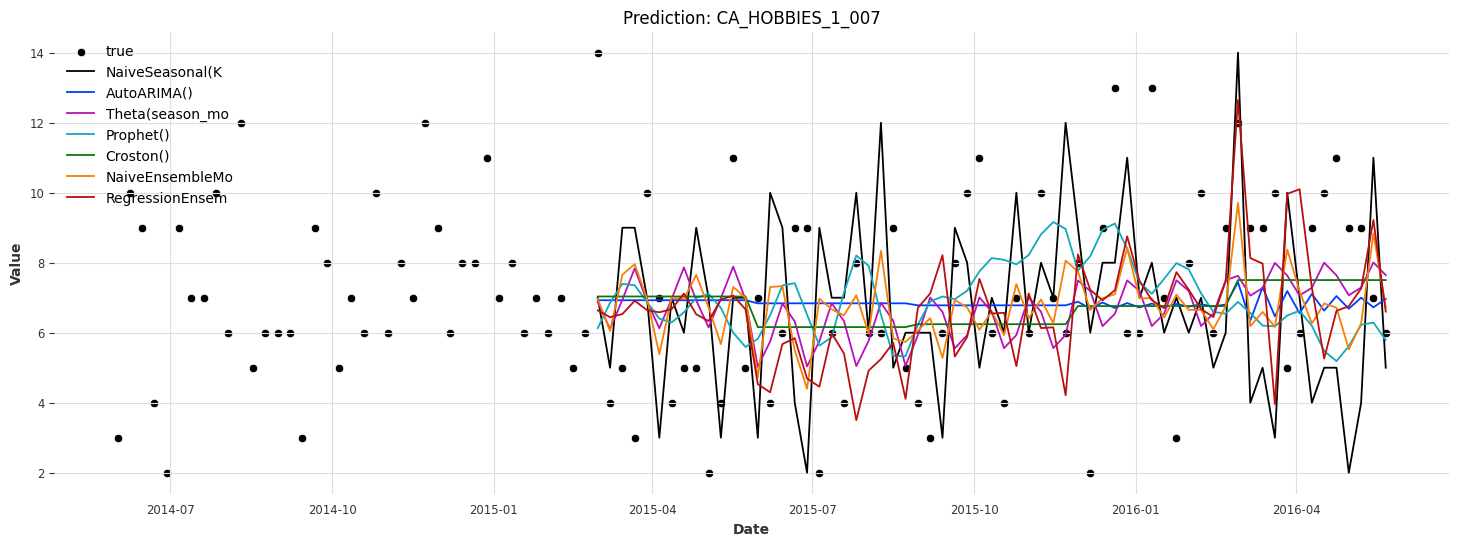

In [ ]:
for i, item in enumerate(list_items[:10]):
  plot_forecasts(list_forecasts[i], plot_n_points, series_name = item)

## Extra: Dynamic inventory policy from forecasts

The code calculates a dynamic basestock inventory policy using previously generated demand forecasts from various models. More specifically, the dynamic basestock (target) inventory level at time $t$, denoted by $S_t$, is calculated by:

$S_t = \sum_{k=t}^{t+L}F_k+SS_t$

where $L$ is the lead time, and $SS_t$ is the dynamic safety stock calculated as follows:

$SS_t = z\times RMSE \times \sqrt{L}$

where $RMSE$ is the standard deviation of the forecasting errors (i.e., root mean squared error). This value is calculated from the reference (initial) periods defined by the parameter `initial_period_split`. The evaluation of the inventory policy starts from the period following the end of the initial periods.

Finally, the code visualizes both the original demand forecasts and the calculated target stock levels against the ideal target stock levels based on the actual demands.

Index(['NaiveSeasonal(K', 'AutoARIMA()', 'Theta(season_mo', 'Prophet()',
       'Croston()', 'NaiveEnsembleMo', 'RegressionEnsem'],
      dtype='object')


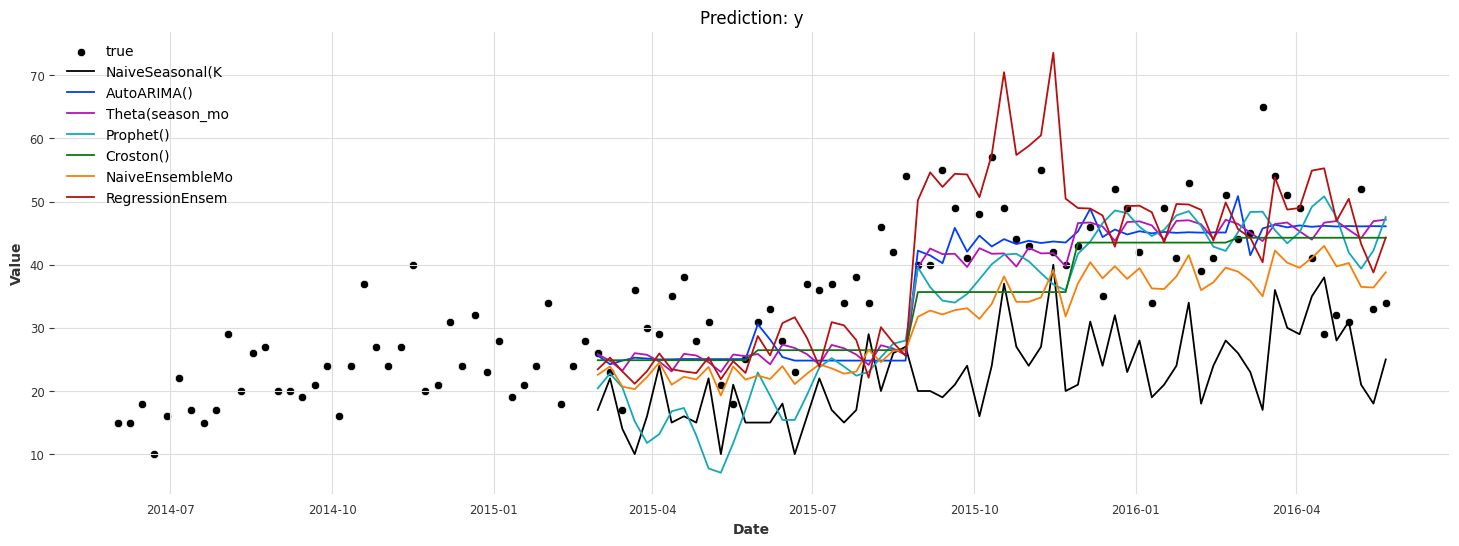

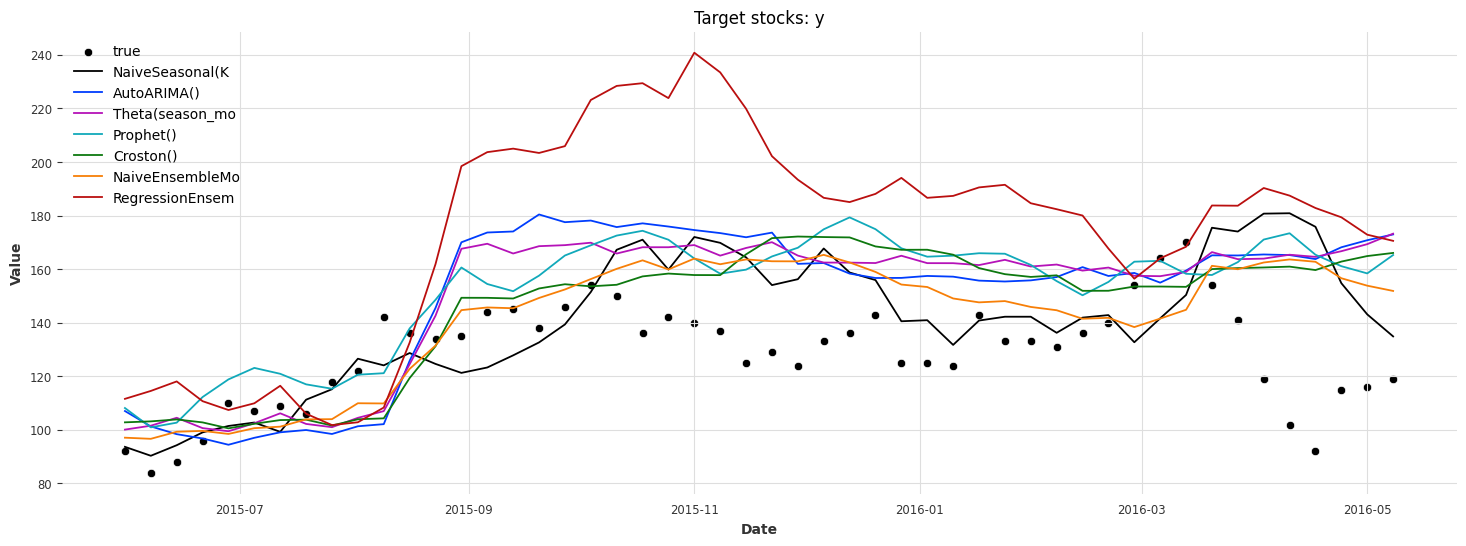

In [ ]:
# dynamic basestock policy simulation

import numpy as np

item_index = 2

forecasts = list_forecasts[item_index][-test_n_points:]
forecast_models = forecasts.columns[1:]
print(forecast_models)

initial_period_split = 13

leadtime = 3
z_score = 1.96

test_forecasts = forecasts[initial_period_split:]
target_stocks = pd.DataFrame(index = test_forecasts.index, columns = test_forecasts.columns)

hist_rmse = []

list_errors = []

for starting_period in range(len(test_forecasts.index)-leadtime+1):
  initial_forecasts = forecasts[starting_period:initial_period_split+starting_period]

  actual_leadtime_demand = sum(test_forecasts['y'].iloc[starting_period: starting_period+leadtime])
  target_stocks['y'].iloc[starting_period] = actual_leadtime_demand

  for model in forecast_models:
    squared_diff = (initial_forecasts['y'] - initial_forecasts[model])**2
    rmse_val = (np.mean(squared_diff))**(1/2)

    exp_leadtime_demand = sum(test_forecasts[model].iloc[starting_period: starting_period+leadtime])
    safety_stock = z_score*rmse_val*(leadtime)**(1/2)
    target_stocks[model].iloc[starting_period] = exp_leadtime_demand + safety_stock
    # print("Model["+str(model)+"], SS: "+str(safety_stock))

plot_forecasts(list_forecasts[item_index], plot_n_points)
plot_forecasts(target_stocks, plot_n_points, plot_name = 'Target stocks')




In [ ]:
# Retrieve and display the forecasting performances for this item based on different models

item = list_items[item_index]
pd_all_errors[pd_all_errors['SeriesName'] == item]

,SeriesName,Model,RMSSE,RMSE,Norm_RMSE,ME,Norm_ME,runtime,Rank_RMSSE,Rank_RMSE,Rank_Norm_RMSE,Rank_ME,Rank_Norm_ME,Rank_runtime
0,CA_HOBBIES_1_005,NaiveSeasonal(K,2.165143,19.488458,0.493283,16.938462,0.428738,0.043788,7.0,7.0,7.0,7.0,7.0,1.0
0,CA_HOBBIES_1_005,AutoARIMA(),1.040675,9.367113,0.237096,2.461986,0.062317,41.903275,1.0,1.0,1.0,2.0,2.0,7.0
0,CA_HOBBIES_1_005,Theta(season_mo,1.046883,9.422998,0.238510,2.700736,0.068360,0.162950,2.0,2.0,2.0,3.0,3.0,3.0
0,CA_HOBBIES_1_005,Prophet(),1.339833,12.059837,0.305253,6.187531,0.156616,2.804850,6.0,6.0,6.0,5.0,5.0,6.0
0,CA_HOBBIES_1_005,Croston(),1.113645,10.023919,0.253721,4.547893,0.115114,0.045083,3.0,3.0,3.0,4.0,4.0,2.0
0,CA_HOBBIES_1_005,NaiveEnsembleMo,1.297373,11.677659,0.295579,8.062364,0.204071,0.290828,5.0,5.0,5.0,6.0,6.0,4.0
0,CA_HOBBIES_1_005,RegressionEnsem,1.260259,11.343592,0.287124,-1.286353,-0.032560,0.442915,4.0,4.0,4.0,1.0,1.0,5.0


In [ ]:
# save the files needed for the simulation (will be performed in a separate notebook)

from google.colab import drive
drive.mount('/content/drive')
test_forecasts.to_csv('/content/drive/My Drive/test_forecasts.csv')
target_stocks.to_csv('/content/drive/My Drive/target_stocks.csv')